### Replication power simulation

Strategy:

- sample subjects from wessel replication 1 in order to create a dataset with particular N (using fabricatr
- fit lmer to dataset 
- create simulate datasets using appropriate value for interaction beta
- run lmer on simulated datasets
    - use condition averages for each subject (as in Wessel paper)
    - use random intercept
- store pvalue and cohen's d for observed effect


In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
import seaborn as sns
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri
import time

pandas2ri.activate()
lme4 = importr('lme4')
stats = importr('stats')
lmerTest = importr('lmerTest')
EMAtools = importr('EMAtools')
fabricatr = importr('fabricatr')
%load_ext rpy2.ipython


/opt/conda/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


Load the data and clean up.

In [2]:
%%R -o rep1Df

library('tidyverse')
rep1Df = read_csv('../processed_data/wessel_replication_1_auction.csv', )
rep1Df['X1'] = NULL
rep1Df = rep1Df %>% 
  mutate(studyNum = 1,
         stimValueFactor = as.factor(auctionStimValue))


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()

R[write to console]: Parsed with column specification:
cols(
  X1 = col_double(),
  auctionStimValue = col_double(),
  auctionCondition = col_character(),
  chosenAuctionAmount = col_double(),
  subcode = col_double()
)



In [3]:
# formula for full mixed model, to generate simulated data
formula = """chosenAuctionAmount ~ 
              auctionStimValue*auctionCondition + 
              (1 + auctionStimValue*auctionCondition|subcode_unique)"""

# formula for random intercept model on summary data
formula3 = """chosenAuctionAmount ~ 
              auctionStimValue*auctionCondition + 
              (1 |subcode)"""

# n from original power analysis 
n = 79

# range of interaction parameters to sample from
int_param_max = 4
int_param_min = 1.5

# data frame to save results
results_sim = pd.DataFrame(columns=['int_param', 'cohensd_int_simple', 'int_pval_simple'])

nruns = 10000
now = time.time()
et = [] # store elapsed time per cycle, to predict finishing time

for i in range(nruns):
    # sample the interaction parameter from the desired range
    int_param = np.random.rand()*int_param_max

    # print status and estimated time to completion
    if i > 0:
        et.append(time.time() - now)
        print(i, int_param, et[-1], 'eta:', (nruns - i)*np.mean(et)/60, 'mins')
        now = time.time()
    
    # create resampled dataset from original
    simDf = fabricatr.resample_data(rep1Df, n, r("c('subcode')"), True)
    
    # fit full lmer model to resampled data
    m1 = lme4.lmer(formula=formula, data=simDf)
    coefs = lmerTest.get_coefmat(m1)
    
    # create simulated response data using specified interaction parameter
    coefs=r('list(beta=c(0,0,0,%f))' % int_param)
    s = lme4.simulate_merMod(m1, newparams=coefs)
    simDf['chosenAuctionAmount'] = s.sim_1.values
    
    # create summary data for simple rmANOVA
    summaryDf = simDf.groupby(['subcode', 
                               'auctionStimValue', 
                               'auctionCondition']).mean().reset_index()

    # fit lmer model with random intercept to summary data
    sm3 = lme4.lmer(formula=formula3, data=summaryDf)
    sm3_coefs = lmerTest.get_coefmat(sm3)
    results_sim.loc[i, 'int_pval_simple'] = sm3_coefs[3,4]
    results_sim.loc[i, 'cohensd_int_simple'] = EMAtools.lme_dscore(
        sm3, summaryDf, 'lme4').loc[
            'auctionStimValue:auctionConditionstop', 'd']
    
results_sim.to_csv('power_sim2_simpleRManova.csv')

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



1 3.5418533327514616 8.731806516647339 eta: 145.3845785021782 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



2 0.7662956033859949 8.073026180267334 eta: 139.76019192934035 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



3 1.357948270138893 8.128255128860474 eta: 138.1016031238768 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



4 1.68995809324687 8.111254930496216 eta: 137.13402243852616 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



5 3.2579309296831735 7.857147216796875 eta: 135.6566084106763 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



6 0.3875435340743212 8.037577390670776 eta: 135.12620266543493 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



7 3.482206948345179 7.8284406661987305 eta: 134.21460827078138 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



8 0.9548664254473191 8.012828826904297 eta: 133.87936283747356 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



9 3.428650421504 8.011622667312622 eta: 133.58672571932829 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



10 2.2871267570331835 7.84313702583313 eta: 133.04790930747984 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



11 0.9181274220634092 8.032094717025757 eta: 132.8664426713279 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



12 3.6203386966962054 7.924784183502197 eta: 132.54565520154105 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



13 1.8817526933798465 8.022549867630005 eta: 132.377610883346 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



14 3.0230198241793693 8.317880868911743 eta: 132.56113392909367 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



15 1.4776922433132755 7.8553149700164795 eta: 132.19545037746428 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



16 1.5508588619807915 7.938600063323975 eta: 131.9444792509079 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



17 3.2316983673422057 7.933224439620972 eta: 131.70228763117512 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



18 3.806658092205155 7.738078832626343 eta: 131.2948770849793 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



19 2.5904979983905734 7.826409101486206 eta: 130.99278680337105 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



20 1.5634989926739098 8.233290433883667 eta: 131.04014795621234 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



21 1.9228479083158772 8.016770601272583 eta: 130.90169733497834 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



22 2.566173034961597 7.917917490005493 eta: 130.69044534293087 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



23 1.0529284534616332 7.828071117401123 eta: 130.422479219022 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



24 0.15417250872360633 8.103784084320068 eta: 130.3528434064653 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



25 3.826672467035614 8.03824234008789 eta: 130.2353712797165 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



26 0.3173662437125242 8.083990097045898 eta: 130.14519305412585 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



27 0.20650434065286527 8.126839876174927 eta: 130.07745078036814 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



28 2.094506712759742 8.091092586517334 eta: 129.98419007062913 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



29 1.5723141823466817 7.967484712600708 eta: 129.81908215078815 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



30 2.871622984924751 7.8724753856658936 eta: 129.60492919418547 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



31 3.2419265597033617 8.093441009521484 eta: 129.5112434921726 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



32 3.41012479025529 8.00596833229065 eta: 129.37088167071343 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



33 0.5223386532807233 8.072688817977905 eta: 129.26352499651185 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



34 1.8265643574398593 8.209721565246582 eta: 129.21945805619745 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



35 3.23832776664697 7.948669672012329 eta: 129.05013088385263 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



36 2.1077174532193172 8.25504732131958 eta: 129.01958610746595 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



37 1.416864552592687 7.9736692905426025 eta: 128.86119819364032 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



38 2.9266177296820195 7.9089295864105225 eta: 128.67683642705282 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



39 2.3715407798782726 8.088926076889038 eta: 128.5690909767762 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



40 0.506243785605784 8.084864616394043 eta: 128.4583674430847 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



41 3.7967819147653565 7.919320106506348 eta: 128.2819365556647 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



42 0.33548854320134947 8.178186416625977 eta: 128.2060322521225 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



43 2.9356237164611145 7.988595485687256 eta: 128.0569936938064 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



44 1.432765379106181 8.34057092666626 eta: 128.03613542246094 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



45 3.4126444536482206 7.967010498046875 eta: 127.87789627755129 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



46 2.019416989433997 8.294965267181396 eta: 127.83412217834722 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



47 2.6657916870680745 7.847497463226318 eta: 127.63510912318603 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



48 0.7870752180981802 8.048217296600342 eta: 127.50528768367236 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



49 0.6299602889777347 8.099554777145386 eta: 127.39189620407261 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



50 3.672163161752093 8.003172397613525 eta: 127.2471195936203 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



51 3.4088113228986336 7.93002986907959 eta: 127.08010592071058 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



52 1.1057102744952818 8.07057237625122 eta: 126.95713579838092 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



53 2.9420871986380535 7.9527881145477295 eta: 126.79865422136376 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



54 0.7732885697902807 7.964371919631958 eta: 126.64451538898328 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



55 0.46071409538753905 7.915525436401367 eta: 126.47716685641896 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



56 3.7035409348595527 8.048634052276611 eta: 126.34848061743237 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



57 1.0369223391106925 7.8584818840026855 eta: 126.16717203513922 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



58 2.2419232863360916 7.935891389846802 eta: 126.00855305647028 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



59 1.954197687007993 7.986997604370117 eta: 125.86441245139657 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



60 2.620377949291197 7.948225736618042 eta: 125.71051554679869 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



61 3.428025913366748 8.436977624893188 eta: 125.68271405208307 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



62 3.5502820731526143 8.467639446258545 eta: 125.65900476504397 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



63 3.287252041333795 7.770187854766846 eta: 125.45868111142407 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



64 3.4497983288060676 7.677172660827637 eta: 125.23789814561606 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



65 2.4035649226672784 7.940204858779907 eta: 125.0830317735672 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



66 2.4332733760769214 7.875088930130005 eta: 124.9134899665611 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



67 1.2981172419645817 8.157613515853882 eta: 124.81066215892338 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



68 1.1773482883757271 8.01585602760315 eta: 124.67447801080404 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



69 2.488204540040786 7.913863897323608 eta: 124.51543292365788 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



70 0.07235713409337707 8.049352884292603 eta: 124.38716460806982 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



71 3.298608101012329 7.863430500030518 eta: 124.21818539978752 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



72 3.680499912591492 8.037470579147339 eta: 124.08764596868446 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



73 1.7333973228104322 8.25074315071106 eta: 124.0021507075388 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



74 2.7811628414712715 8.3270103931427 eta: 123.93115576430483 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



75 3.339872882531643 8.095836639404297 eta: 123.81083407666947 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



76 0.6353811236364426 8.068163871765137 eta: 123.6845205670909 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



77 2.5027762383570464 7.8254406452178955 eta: 123.50950310844362 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



78 0.27017771463972506 8.109379291534424 eta: 123.39156741168763 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



79 1.3311054614149191 8.12911343574524 eta: 123.27703016890754 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



80 3.371993147184661 8.28528881072998 eta: 123.19190284013747 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



81 1.1398090428498446 8.012484550476074 eta: 123.05388201067967 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



82 2.69328843842587 7.900582313537598 eta: 122.89509111555611 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



83 2.6984582324866473 7.812388896942139 eta: 122.72071395131002 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



84 0.14273465906673266 8.017688035964966 eta: 122.58470077382192 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



85 1.8629607037134295 7.895999431610107 eta: 122.42691134775387 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



86 2.0926465293533223 8.113421201705933 eta: 122.30824328411457 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



87 1.404756394147665 8.014682531356812 eta: 122.17192482185547 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



88 0.6386309551864979 7.96967887878418 eta: 122.02789528369904 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



89 2.0821827304405436 7.920202016830444 eta: 121.87567675033311 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



90 2.2513746714214733 8.08658480644226 eta: 121.75194602409996 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



91 1.8812830911381386 7.906725168228149 eta: 121.5980288704673 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



92 0.08650501500800845 8.452314853668213 eta: 121.53433853612431 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



93 1.9035049493349385 7.9899985790252686 eta: 121.39384127513485 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



94 1.3134508639691176 8.132773160934448 eta: 121.27643505055853 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



95 1.7157908720298334 8.062914848327637 eta: 121.1475553922486 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



96 3.689216246597837 7.866073846817017 eta: 120.98766800198291 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



97 2.554515788488687 8.28177523612976 eta: 120.89287213984225 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



98 2.7867402587516548 8.251490116119385 eta: 120.79254817816675 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



99 0.4786282323071607 8.075528621673584 eta: 120.66478222805242 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



100 3.1221447782866503 7.870479345321655 eta: 120.50612236261368 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



101 1.3910382175331732 7.992443561553955 eta: 120.36610013010477 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



102 3.6235370416555925 7.846471309661865 eta: 120.20479271762512 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



103 1.9330641197828733 8.040649652481079 eta: 120.0722623149168 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



104 3.502885540813456 7.880270719528198 eta: 119.9166746726403 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



105 3.804395625394178 7.86774206161499 eta: 119.75976906636404 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



106 0.15102072607929173 7.907338380813599 eta: 119.60891570819999 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



107 2.573577847214501 8.338542222976685 eta: 119.51839767048293 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



108 2.5534605644070147 8.097187042236328 eta: 119.39375868505901 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



109 2.019541833471193 7.952977418899536 eta: 119.24928354210809 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



110 0.15209445310904668 8.171350717544556 eta: 119.13447253523451 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



111 2.433304027279391 8.016551733016968 eta: 118.99861322838267 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



112 0.023423969177722714 7.890494346618652 eta: 118.8461365188871 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



113 3.032452754206492 7.787428140640259 eta: 118.6805471975543 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



114 1.0552569789504487 7.908087491989136 eta: 118.53121519311826 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



115 0.5507746561098998 8.109216928482056 eta: 118.40798510416694 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



116 2.9110772106277687 7.999863862991333 eta: 118.27066034092302 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



117 2.5032011903967804 7.9208574295043945 eta: 118.12346614222241 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



118 3.0874253528791713 7.93654203414917 eta: 117.97848315966331 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



119 3.129477242219726 8.011931896209717 eta: 117.8430160513779 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



120 2.6322809219899286 7.8961803913116455 eta: 117.69343378543856 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



121 3.8498435999221607 7.975625038146973 eta: 117.55376740871382 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



122 1.2861034062012258 8.061188697814941 eta: 117.42447447574855 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



123 3.6891594964783936 7.806399345397949 eta: 117.2648214496248 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



124 1.4844948790565078 8.041218757629395 eta: 117.13329306994714 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



125 1.3692730687277463 7.949694871902466 eta: 116.99104703267413 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



126 3.1204661627542274 7.98401403427124 eta: 116.85292336082964 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



127 1.4328129108393832 7.9937145709991455 eta: 116.71599068388227 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



128 3.6311331073596556 7.891894578933716 eta: 116.56755507191022 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



129 2.094300437384616 7.933505296707153 eta: 116.42406408777533 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



130 2.234911150182286 7.8991522789001465 eta: 116.27691474235975 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



131 0.9247662743798633 8.178827285766602 eta: 116.16092280125194 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



132 3.5880362968199764 8.109669923782349 eta: 116.0370435859218 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



133 2.4588630043146065 7.986466407775879 eta: 115.89960907204707 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



134 2.794012470302901 7.843966245651245 eta: 115.74689023832775 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



135 3.4677366385331525 8.119940996170044 eta: 115.62396850173855 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



136 2.853103164000482 7.86951208114624 eta: 115.47434825336232 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



137 2.7866452079759125 7.962115526199341 eta: 115.33471975422253 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



138 0.7921937510908243 7.671129941940308 eta: 115.16489821344182 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



139 3.6750455065784995 8.078429937362671 eta: 115.03772914521129 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



140 2.653332391244925 8.026368856430054 eta: 114.90512327920824 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



141 0.34480311516779016 8.036335706710815 eta: 114.7735128612665 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



142 1.6394989105526827 8.071498394012451 eta: 114.64541067858818 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



143 2.0650023731213123 7.905182838439941 eta: 114.50060649521146 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



144 3.874809258334472 8.069997072219849 eta: 114.37231239521945 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



145 0.8642194129442098 7.955573081970215 eta: 114.23268758099654 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



146 2.3574003709916247 8.12178897857666 eta: 114.10936324705271 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



147 0.1792693852984346 7.979412794113159 eta: 113.97210563156341 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



148 2.4739815841069737 8.044519901275635 eta: 113.84115244665662 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



149 3.3710053178492716 7.822744846343994 eta: 113.68904655153054 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



150 0.702797285713662 8.038691997528076 eta: 113.55762535598542 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



151 0.35129611973919683 7.890178203582764 eta: 113.41225327174395 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



152 3.228078968488332 8.219301223754883 eta: 113.29766634263491 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



153 3.6853178568994838 7.942465782165527 eta: 113.15724414228613 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



154 2.038518308024296 8.096525192260742 eta: 113.031031897935 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



155 1.2601596969127478 8.167251110076904 eta: 112.91113318256153 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



156 2.4362432696725262 7.955728054046631 eta: 112.77195325824951 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



157 3.4576459753388904 8.098104238510132 eta: 112.64559852059479 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



158 1.020622254560207 8.222076654434204 eta: 112.53014580132087 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



159 2.02874178309011 7.834146976470947 eta: 112.38022361808852 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



160 2.733242475778701 8.072864294052124 eta: 112.25143111348152 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



161 0.13865320993945218 8.104321241378784 eta: 112.12529924560037 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



162 2.0192507134696567 7.879212856292725 eta: 111.97964951300328 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



163 1.377755532935427 8.019566535949707 eta: 111.8461874667121 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



164 1.6129534464292377 8.235252141952515 eta: 111.7310475219556 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



165 0.7502418371698552 7.985129356384277 eta: 111.59454331084935 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



166 1.8768193607377088 8.091870069503784 eta: 111.46701821634568 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



167 2.869273698542674 7.95882773399353 eta: 111.32834491882019 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



168 0.46686376076835767 8.282515525817871 eta: 111.21646044897653 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



169 0.22956977731103656 7.983274698257446 eta: 111.0797428408318 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



170 1.1576729302939954 8.038197994232178 eta: 110.94753757574979 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



171 3.7039071486424153 8.106465816497803 eta: 110.82082765769309 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



172 2.139300154227274 7.7600860595703125 eta: 110.66622915628345 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



173 2.59822983483663 8.104056119918823 eta: 110.53932765756728 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



174 1.0505305393127635 7.965824365615845 eta: 110.4013955686741 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



175 3.6382440266532936 8.203381538391113 eta: 110.28218775306429 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



176 3.8385888908261028 8.1677565574646 eta: 110.16000107291974 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



177 2.641629462728241 8.301300048828125 eta: 110.04800584116448 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



178 3.0944439153350003 7.925593614578247 eta: 109.9067977010534 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



179 1.6792350353626375 8.057457447052002 eta: 109.77577149725938 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



180 0.20522102776658135 7.893194198608398 eta: 109.63223717919101 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



181 0.8155771622580978 8.164328575134277 eta: 109.50928267550073 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



182 1.5425134773296438 7.847084283828735 eta: 109.36241975175591 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



183 2.9928574546786284 7.932782173156738 eta: 109.2221091556853 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



184 2.1479114255652307 8.181832551956177 eta: 109.10029464804607 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



185 2.855477657298844 7.910000562667847 eta: 108.95836401468998 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



186 2.3448477281911466 7.999437093734741 eta: 108.82306537158173 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



187 3.467177887815266 8.07829999923706 eta: 108.69350224586732 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



188 0.8879949175884616 7.9934282302856445 eta: 108.557775565073 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



189 0.0900361060193875 8.233407974243164 eta: 108.43923794226673 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



190 3.5336641695338487 8.305167436599731 eta: 108.32560232501281 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



191 0.957294358310008 7.760321855545044 eta: 108.17324470637355 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



192 2.1162469240198516 8.210521936416626 eta: 108.05270340161191 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



193 2.292428029744632 8.072378158569336 eta: 107.92236605919705 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



194 3.609605666160786 8.05458116531372 eta: 107.79075305941178 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



195 2.506826817060819 7.884633302688599 eta: 107.64742009109922 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



196 3.1765882395723763 7.993590831756592 eta: 107.51165791725626 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



197 2.4377417529057737 7.866143703460693 eta: 107.36726327600012 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



198 3.252022783015367 7.944087743759155 eta: 107.22826477867186 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



199 2.477279381228994 8.134772539138794 eta: 107.10212475414852 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



200 3.84476618245646 7.884617567062378 eta: 106.95921333630879 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



201 1.7278974898116206 8.139650106430054 eta: 106.83331279193187 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



202 3.8048850966995675 8.03350830078125 eta: 106.70032706638374 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



203 1.660336062917811 8.069177150726318 eta: 106.56966641011887 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



204 1.2378366027221048 8.055113554000854 eta: 106.43805365429984 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



205 1.5571378612565074 7.935342073440552 eta: 106.29867382340315 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



206 1.9569693335467115 7.858488321304321 eta: 106.15442611357155 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



207 1.2301720395970408 8.110862731933594 eta: 106.02642040504156 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



208 3.4354093100818224 7.979994535446167 eta: 105.89004060580181 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



209 0.4788395102429175 8.125872373580933 eta: 105.76289485415394 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



210 3.489278292017524 8.051766872406006 eta: 105.63102389611895 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



211 1.8175330249225468 7.893590450286865 eta: 105.48927298422674 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



212 1.2530769843455984 8.326538801193237 eta: 105.37443922870564 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



213 3.618484457674516 7.976612091064453 eta: 105.23783197179087 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



214 1.128753412822375 8.228826999664307 eta: 105.11669827911342 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



215 1.1068695563245075 7.959287881851196 eta: 104.97901343772578 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



216 3.7548972168303067 8.162633419036865 eta: 104.85367632059405 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



217 0.7148383381619099 8.005620956420898 eta: 104.71879806897608 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



218 0.5586574704531642 8.08869194984436 eta: 104.58889960827084 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



219 0.5967127780713559 8.140044927597046 eta: 104.46200853774899 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



220 0.09154863473112407 8.071292161941528 eta: 104.33097501884808 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



221 2.3639009758990834 8.121289014816284 eta: 104.20284715502511 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



222 3.208178313652795 7.993088960647583 eta: 104.06716622239476 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



223 3.007410876460202 8.059630632400513 eta: 103.93537156875894 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



224 2.206775548622597 8.128651142120361 eta: 103.80753941606909 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



225 3.6903598502857595 8.11635947227478 eta: 103.67893367166873 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



226 1.2761958735587768 7.86566948890686 eta: 103.5359596325233 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



227 3.953506107328123 7.911348342895508 eta: 103.39568275195737 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



228 0.2552653391104669 7.839557647705078 eta: 103.25142839422003 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



229 3.941155811938327 7.912109851837158 eta: 103.11136393146222 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



230 1.4929831100317146 8.216903924942017 eta: 102.98837736378546 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



231 1.4733144403853191 7.920618534088135 eta: 102.84883099197481 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



232 3.125840136585384 8.133467197418213 eta: 102.72109296075229 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



233 0.761793352788894 8.007825374603271 eta: 102.5863945826952 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



234 0.9969854290367404 7.910957336425781 eta: 102.44642179134566 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



235 2.3922790010395043 7.868894577026367 eta: 102.3042360077513 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



236 0.27058167958032975 8.108556509017944 eta: 102.17507467478683 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



237 2.7782225299440846 8.116129398345947 eta: 102.04626920409345 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



238 0.1074386176930684 8.027462720870972 eta: 101.91267804638679 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



239 3.4574466418051477 7.98817777633667 eta: 101.77700042917472 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



240 2.1209916633282364 7.873737573623657 eta: 101.63530409004952 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



241 3.9629618605108323 7.900913238525391 eta: 101.4951210576469 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



242 2.773615588579038 8.023429155349731 eta: 101.36140408601314 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



243 0.6160534399893902 8.149163722991943 eta: 101.23421525196449 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



244 0.17116787289367563 8.051493167877197 eta: 101.10191203218992 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



245 1.81224031831671 7.894389629364014 eta: 100.96152447421535 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



246 1.9705656948707517 8.291754245758057 eta: 100.84150755638031 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



247 2.7978745048304625 7.949414014816284 eta: 100.70394923016129 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



248 0.9234885431717919 7.956819534301758 eta: 100.56680603309343 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



249 3.8005958879641386 8.094153881072998 eta: 100.43660270476757 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



250 1.4654094181352622 8.181615352630615 eta: 100.31073485612869 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



251 1.9875741993437455 7.976230621337891 eta: 100.17456871714407 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



252 2.5206812121424065 8.06949520111084 eta: 100.04304208749186 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



253 1.1861709269426588 8.190204858779907 eta: 99.91743207967328 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



254 0.10319423987422871 8.038636684417725 eta: 99.78431701497456 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



255 0.5041841664616618 8.165595769882202 eta: 99.65737718250236 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



256 1.6652900874476502 7.843588829040527 eta: 99.51476862765848 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



257 3.986767163344569 7.9203057289123535 eta: 99.37594908095521 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



258 2.5724098612831954 7.9333655834198 eta: 99.23780835506527 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



259 1.9241377238249417 7.952108383178711 eta: 99.1006070481304 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



260 1.338890874908501 8.351423501968384 eta: 98.98238350580901 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



261 3.7957919102807645 7.987932920455933 eta: 98.84684607066109 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



262 2.806226130476606 8.104221105575562 eta: 98.71678632679784 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



263 3.270253563411553 7.910816669464111 eta: 98.57765558531983 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



264 0.741771042825718 7.823745965957642 eta: 98.43453431466612 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



265 1.4816971736051388 8.052682161331177 eta: 98.30209198515371 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



266 3.2274637734864737 7.996169805526733 eta: 98.16703735276272 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



267 2.6236301011953658 7.803588151931763 eta: 98.02318445970948 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



268 0.2556375036266276 8.300343990325928 eta: 97.90204801221392 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



269 1.9746425340746088 8.056830167770386 eta: 97.76975463048234 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



270 0.08138995854558395 8.15915584564209 eta: 97.64205750123953 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



271 3.562405742410478 8.018066167831421 eta: 97.50797359270364 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



272 0.1422550283573969 8.00839114189148 eta: 97.3734614070724 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



273 2.766089523876364 8.087215423583984 eta: 97.24245532234364 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



274 2.5216591673591973 8.017108678817749 eta: 97.10832568546282 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



275 0.6957831005345088 8.069400787353516 eta: 96.97649744965813 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



276 0.0730503460837637 8.030601978302002 eta: 96.84295364917764 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



277 1.7129258279982897 8.018725633621216 eta: 96.70889104333595 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



278 1.4716505856853805 7.945858001708984 eta: 96.57167733624686 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



279 3.5033279363130823 8.033473253250122 eta: 96.43827154583686 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



280 0.3616207735530641 8.017994403839111 eta: 96.30419890880584 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



281 1.5154742635271252 8.02147650718689 eta: 96.17027789454725 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



282 0.40687968391405294 7.839457035064697 eta: 96.02863451549631 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



283 1.3284602877054592 8.027124166488647 eta: 95.89499323448108 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



284 2.060261424824839 8.486472606658936 eta: 95.78065219927284 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



285 2.2021159461233415 7.914166688919067 eta: 95.64219123703695 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



286 2.757216809268854 7.938666582107544 eta: 95.50479553737841 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



287 1.321780400947477 7.952605247497559 eta: 95.3680124056187 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



288 2.98824303814492 7.986294746398926 eta: 95.23264684842691 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



289 2.0884671115349165 7.829406261444092 eta: 95.09086396508565 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



290 1.4483542669288108 8.042645454406738 eta: 94.95786010246167 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



291 0.8612378323398926 8.004351377487183 eta: 94.82329407901699 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



292 1.0736147603747428 8.084507942199707 eta: 94.69197520556514 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



293 1.0091343010100142 7.858421087265015 eta: 94.55154062349506 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



294 1.7020815380264183 7.934979200363159 eta: 94.414234461806 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



295 1.7147273089370185 8.023741960525513 eta: 94.28049804740031 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



296 2.952191293468928 8.03474736213684 eta: 94.1471979330252 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



297 0.374860368206162 7.860458850860596 eta: 94.00701800358684 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



298 3.107617416805665 8.096674919128418 eta: 93.87617388811688 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



299 1.476897868128162 8.13455080986023 eta: 93.7467823335957 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



300 2.993068929790079 7.9486658573150635 eta: 93.61012069119347 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



301 2.600488949999015 8.12589716911316 eta: 93.48034646586326 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



302 2.6609185448007047 8.076408386230469 eta: 93.34862841836139 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



303 1.3677899356042449 7.962432146072388 eta: 93.21252158700568 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



304 0.667413747322791 8.027220964431763 eta: 93.0789093265408 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



305 3.99944578060354 7.788485288619995 eta: 92.9362291827228 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



306 0.7726032017699338 8.01793885231018 eta: 92.80230641471535 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



307 0.44322676891609447 7.871516227722168 eta: 92.66287680499327 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



308 2.1624412902659764 7.982412338256836 eta: 92.52765328992497 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



309 3.2322430029563685 7.985323667526245 eta: 92.39255241378098 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



310 3.637771638689402 7.805130481719971 eta: 92.25077993331418 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



311 1.2906074823474132 8.06743335723877 eta: 92.11876785573726 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



312 1.881435452403303 7.92848014831543 eta: 91.98163327681712 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



313 3.6990956417311915 8.137454271316528 eta: 91.85217518414171 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



314 0.006376373787019496 8.16946291923523 eta: 91.72384331201039 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



315 3.944714507494968 7.819074869155884 eta: 91.58276250255172 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



316 3.848141871254863 7.926303386688232 eta: 91.44561818325066 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



317 0.13050226897792427 8.184495449066162 eta: 91.31777722305304 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



318 3.4786271502454684 7.942070007324219 eta: 91.1812170685712 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



319 1.6725507470391223 7.949324607849121 eta: 91.0449413164656 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



320 2.24353093950388 7.848808526992798 eta: 90.90512928863366 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



321 1.6684048276741659 8.075212001800537 eta: 90.77335504822024 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



322 0.7365433062311935 7.900862455368042 eta: 90.63544486020663 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



323 1.9193741913847262 8.06470251083374 eta: 90.50329665440155 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



324 3.539562834791378 8.204148292541504 eta: 90.37598351691486 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



325 0.38006076464175464 7.849353790283203 eta: 90.2363310456276 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



326 1.171854434897401 7.975085020065308 eta: 90.10106520204212 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



327 3.4389302413093645 8.012089252471924 eta: 89.96708302714165 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



328 0.4354311281953507 8.059156894683838 eta: 89.8347107677925 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



329 1.6316645033032868 8.076165676116943 eta: 89.7029048331482 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



330 2.247584089071654 8.27067518234253 eta: 89.57766383537138 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



331 2.7819248398735175 8.268986225128174 eta: 89.45228978910475 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



332 0.7965727464890309 7.866180181503296 eta: 89.31333303580801 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



333 0.5128713268354583 7.991317510604858 eta: 89.17860095961555 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



334 1.4136749888800457 8.035939455032349 eta: 89.04536107050444 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



335 1.4026129764224335 8.040002584457397 eta: 88.912251474371 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



336 1.1155985292454638 7.940019369125366 eta: 88.77584347999284 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



337 1.7149367655044951 7.923103332519531 eta: 88.6389050003683 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



338 0.008794674715556727 8.064044952392578 eta: 88.50659619348761 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



339 3.165311677900701 7.883493185043335 eta: 88.36840755615965 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



340 1.22165922652017 8.174391746520996 eta: 88.23967032572801 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



341 3.1780942788474187 8.049034833908081 eta: 88.1068514471413 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



342 1.5401550673340698 8.195321798324585 eta: 87.97871565911737 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



343 0.9386420087214562 8.241897106170654 eta: 87.85201746235784 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



344 3.023307735254357 8.131234407424927 eta: 87.72174006303152 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



345 2.0579738658235924 7.894985675811768 eta: 87.58395676514952 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



346 1.509126871984559 7.94111704826355 eta: 87.4476625781528 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



347 0.8750387964642181 7.965224027633667 eta: 87.31214720603943 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



348 1.8256485262736617 7.907702922821045 eta: 87.17485154830634 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



349 3.7759566319532345 7.986487627029419 eta: 87.04003673658671 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



350 3.7072326043769546 8.04530930519104 eta: 86.90705234834127 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



351 1.670428429567289 7.984775066375732 eta: 86.77219620259285 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



352 2.5837970231353147 8.235458850860596 eta: 86.6450415852395 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



353 2.7999984060414755 7.8150060176849365 eta: 86.50498586558754 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



354 2.867936238109316 7.7826831340789795 eta: 86.36400246662834 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



355 2.6001653644278684 7.96019983291626 eta: 86.22845807763892 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



356 2.9675375343734975 7.920933246612549 eta: 86.09174595669415 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



357 1.9227990836127158 8.007081985473633 eta: 85.95764621796728 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



358 2.0282055131040235 8.009388446807861 eta: 85.82361903756691 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



359 2.0024265964911536 8.056758642196655 eta: 85.69100452104763 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



360 1.6746948219120608 8.19845199584961 eta: 85.56257907726147 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



361 0.4707465017235455 8.044902324676514 eta: 85.42957819069521 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



362 3.028295226378214 7.920223951339722 eta: 85.29290904904377 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



363 0.39217841205313375 8.16549277305603 eta: 85.16343899318336 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



364 2.794112416161436 8.004301071166992 eta: 85.02923851144183 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



365 1.7174946454603304 7.903543472290039 eta: 84.89212087811944 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



366 2.9861430014400656 8.027608633041382 eta: 84.75861455358444 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



367 2.0911775732044613 8.01580548286438 eta: 84.62476736381853 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



368 0.3838964900158248 8.021812200546265 eta: 84.4910934665065 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



369 2.9678266869505157 8.06407642364502 eta: 84.35862399412902 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



370 0.9002125125629572 7.809626817703247 eta: 84.21892321238647 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



371 0.8271148311548955 8.055659770965576 eta: 84.0862260051172 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



372 3.1944006645633682 8.130283832550049 eta: 83.95562002795572 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



373 1.572092438952672 8.061396598815918 eta: 83.82305783336987 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



374 0.27741804599541986 8.057815313339233 eta: 83.6903861372441 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



375 1.724670510418973 8.092245817184448 eta: 83.5586621761322 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



376 0.994509422232257 8.067681074142456 eta: 83.42624202636962 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



377 3.9873930862474203 7.9852118492126465 eta: 83.29153968070482 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



378 3.6433707265818263 8.144551277160645 eta: 83.16121577339828 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



379 1.1585886022372431 8.400222301483154 eta: 83.03784531694603 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



380 0.8780617524087635 7.9785425662994385 eta: 82.90292058743928 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



381 0.7658948550392481 7.928518772125244 eta: 82.76665155145022 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



382 2.683355405559258 8.071382999420166 eta: 82.6342562213618 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



383 2.5077291946382867 8.085853576660156 eta: 82.50223830727727 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



384 2.173172383896283 7.910768508911133 eta: 82.36552499565815 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



385 0.40332636331000593 8.168409824371338 eta: 82.23569624981323 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



386 1.727533048714489 7.874982833862305 eta: 82.09805569298732 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



387 2.4704382792699695 8.092331409454346 eta: 81.96618609128586 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



388 1.3473414515624325 7.977562427520752 eta: 81.83128388960337 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



389 1.6732157177166571 7.973667860031128 eta: 81.69628972385107 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



390 1.7216013107583161 7.995710372924805 eta: 81.56188093831398 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



391 2.1436092977839682 8.075066328048706 eta: 81.42953802703897 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



392 3.5820474648323684 7.908148765563965 eta: 81.29286880363412 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



393 0.5188410471859033 8.101503372192383 eta: 81.16120171150583 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



394 2.6830118178914644 7.9755589962005615 eta: 81.02628905053068 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



395 1.6722871438915372 8.027856349945068 eta: 80.8927214655192 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



396 1.035469474381384 8.01764464378357 eta: 80.75889312827627 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



397 2.9128639289344203 7.909125804901123 eta: 80.62231866388538 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



398 2.420030566505804 7.940345764160156 eta: 80.48655513331319 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



399 1.5222512833455117 8.225877285003662 eta: 80.35797687325761 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



400 0.6154032325639394 8.58662724494934 eta: 80.2383747637272 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



401 3.904490106386796 8.039375066757202 eta: 80.10503096441775 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



402 0.7970210213273696 8.029015064239502 eta: 79.97142709977986 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



403 0.908448557013315 8.111362218856812 eta: 79.83985531475054 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



404 0.0480342015162365 7.926921367645264 eta: 79.70373068906292 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



405 0.8275320472137935 7.975165843963623 eta: 79.56880715702786 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



406 3.598369982728357 7.918281078338623 eta: 79.43250640583742 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



407 1.6489550249458835 8.021947383880615 eta: 79.29874429703735 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



408 3.7622486213357575 8.259646654129028 eta: 79.17073077999687 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



409 2.561397901085449 8.016080856323242 eta: 79.03680426141744 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



410 3.6309062260124056 7.870375394821167 eta: 78.8993847671563 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



411 3.1401989094597296 8.025962352752686 eta: 78.76571183845655 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



412 3.429587720717147 7.84477972984314 eta: 78.62772877401518 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



413 3.368968094635622 8.164482355117798 eta: 78.49735401664846 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



414 2.067198328293672 7.923584461212158 eta: 78.36126870535037 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



415 1.5539252947178284 8.048258304595947 eta: 78.22813187866326 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



416 1.532580505790111 8.190635442733765 eta: 78.09832150034416 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



417 3.130138931546742 8.176196575164795 eta: 77.96814254147829 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



418 3.6226881257437156 8.001961469650269 eta: 77.83389118430718 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



419 2.777554766186709 7.929698705673218 eta: 77.69797401862573 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



420 1.408112740282439 8.04060411453247 eta: 77.56462732118274 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



421 3.3857420364880766 8.12205171585083 eta: 77.43314438290948 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



422 2.086083476092604 8.059125900268555 eta: 77.30020657606411 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



423 2.076117366845162 8.207761764526367 eta: 77.17064139249288 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



424 1.6102622240702766 7.991070985794067 eta: 77.03613589484736 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



425 1.2100367539651966 7.851951599121094 eta: 76.8984996078061 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



426 1.7687834484846388 8.069229364395142 eta: 76.7657745057615 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



427 1.3911882579290133 7.9991888999938965 eta: 76.63147467176584 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



428 1.8595784559769641 8.100044012069702 eta: 76.49942587851736 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



429 3.187668904946537 7.9465179443359375 eta: 76.3639575974091 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



430 2.056093841855941 8.083473205566406 eta: 76.23152914795764 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



431 2.8180660441960383 7.98141622543335 eta: 76.09684447444693 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



432 0.20246892883806877 8.450175523757935 eta: 75.97243968557429 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



433 0.9552367765340244 8.063588619232178 eta: 75.83952194245803 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



434 3.779719935363604 7.973643064498901 eta: 75.70464236247375 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



435 3.691045968863825 7.898857355117798 eta: 75.56815298699784 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



436 2.1097628074198367 8.11626124382019 eta: 75.43637296945676 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



437 3.253317707945339 8.083783388137817 eta: 75.30387960511433 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



438 3.489249824902015 8.128262281417847 eta: 75.17232721394417 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



439 0.8765183761482662 7.971841335296631 eta: 75.03742545343476 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



440 1.0018879566161463 7.920303821563721 eta: 74.9014397353837 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



441 0.9316370002615879 7.97297477722168 eta: 74.76658480881923 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



442 1.5101782636053502 7.885131120681763 eta: 74.62989051126247 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



443 1.978668828422479 8.052186012268066 eta: 74.49672076705706 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



444 1.3396763378207153 8.128226041793823 eta: 74.36513338973214 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



445 1.8658449326486366 8.394916772842407 eta: 74.2390721318427 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



446 1.790213880980318 8.125909328460693 eta: 74.10737961062046 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



447 2.8042413130298987 7.9075610637664795 eta: 73.97116824873875 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



448 3.738471591767315 8.046242475509644 eta: 73.83782453494412 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



449 2.0593821097341634 8.007818698883057 eta: 73.7036915583352 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



450 1.2286140495941371 8.017208337783813 eta: 73.56975282695558 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



451 2.203742179827735 8.2621488571167 eta: 73.44078492248667 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



452 3.347879686379179 7.903979778289795 eta: 73.30454102965584 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



453 1.4608006495430965 8.012379884719849 eta: 73.17049861459545 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



454 0.24054582262100865 8.038796424865723 eta: 73.03698790882127 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



455 1.3541774025686864 7.855226993560791 eta: 72.89981047600618 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



456 1.018506848162502 8.080063104629517 eta: 72.76713091169881 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



457 2.519217069101675 8.063310861587524 eta: 72.63411090076622 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



458 0.1409785168017592 7.9216978549957275 eta: 72.49829181887351 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



459 0.2925156299930274 7.951012134552002 eta: 72.36306510878026 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



460 0.1607967911450081 8.211835622787476 eta: 72.23295324885325 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



461 1.4400458916807324 7.810613632202148 eta: 72.09499363401018 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



462 3.940994330469408 8.039336919784546 eta: 71.96150685665755 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



463 2.9088795426863086 8.04524040222168 eta: 71.82813202709153 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



464 1.406962536972948 8.22968578338623 eta: 71.69830522996254 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



465 3.2778977159010214 7.9950644969940186 eta: 71.56394787569629 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



466 2.2766143791499203 8.165188074111938 eta: 71.43284441068961 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



467 0.7046215608866895 7.932947635650635 eta: 71.2973018980724 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



468 1.9868163779118326 7.87883996963501 eta: 71.16074848545243 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



469 1.8665878875625994 8.060953140258789 eta: 71.02765387962621 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



470 2.7971634137652757 8.044879674911499 eta: 70.89425184506896 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



471 0.449027980872295 7.924177408218384 eta: 70.75858749578123 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



472 3.096302379952908 8.028570890426636 eta: 70.62488469754234 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



473 1.506251636710561 8.068689107894897 eta: 70.49192641990297 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



474 1.402040346245717 8.25955080986023 eta: 70.36249173123458 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



475 1.9523337660676119 8.04267168045044 eta: 70.22902727127075 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



476 1.2941196809981816 7.976539134979248 eta: 70.0943470178198 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



477 2.110907390255105 8.1200852394104 eta: 69.9622972033892 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



478 2.5144286918926015 8.116979837417603 eta: 69.83017712352665 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



479 2.047933865835986 7.935688257217407 eta: 69.69475737548821 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



480 3.9602808565212304 7.940429449081421 eta: 69.55943639179071 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



481 0.27573413420965975 8.218091249465942 eta: 69.42912109532624 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



482 3.228886740481416 7.8602025508880615 eta: 69.2923678772578 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



483 0.7920969825297464 7.891112327575684 eta: 69.15618989506288 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



484 2.4635073712989195 7.9255735874176025 eta: 69.02064349493705 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



485 3.563475709287633 8.064931154251099 eta: 68.88757762978577 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



486 1.5720028570890912 8.08877158164978 eta: 68.75492644300185 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



487 2.6354092734359074 7.905521869659424 eta: 68.61904916097497 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



488 0.7226778718974742 7.975630044937134 eta: 68.4844146936969 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



489 0.8298955922986226 8.146580934524536 eta: 68.35276457476795 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



490 0.9318499933001068 7.954533338546753 eta: 68.21776617619456 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



491 2.3580266008416033 7.887855052947998 eta: 68.08162560157847 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



492 0.8411861583649354 7.856290578842163 eta: 67.94496085372398 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



493 2.1292701163508423 8.041133880615234 eta: 67.8114875440907 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



494 0.9567462199162025 7.839214563369751 eta: 67.67456495493208 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



495 2.162970533600014 8.037942171096802 eta: 67.54104673356721 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



496 0.42502416050157876 8.080138444900513 eta: 67.40824132215592 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



497 3.8234669984212712 8.127612113952637 eta: 67.27622919136209 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



498 3.7512954382908017 7.857611179351807 eta: 67.13966705261305 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



499 3.8697603520047243 8.218021154403687 eta: 67.0091582749793 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



500 3.260935006926178 7.927014589309692 eta: 66.87377355496089 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



501 1.6926794058528158 8.139124631881714 eta: 66.74192293502455 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



502 0.756946611112733 7.927405595779419 eta: 66.6065566359763 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



503 3.0896173173570673 8.10605502128601 eta: 66.47414520469384 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



504 2.1219112178412542 8.032428979873657 eta: 66.34051547794746 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



505 1.514120530867003 8.07746958732605 eta: 66.20762059641356 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



506 3.313840805206327 7.800786018371582 eta: 66.07021684674878 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



507 2.5513743505126265 7.920893907546997 eta: 65.93478877319465 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



508 0.5185937233445284 7.926444053649902 eta: 65.79946372631028 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



509 0.2188234206543691 8.069795846939087 eta: 65.66645602873906 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



510 0.9094065759376306 7.935429096221924 eta: 65.5312908679052 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



511 3.152440654429891 8.029401779174805 eta: 65.39763587025047 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



512 0.5085565640718714 7.837136507034302 eta: 65.26092600096017 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



513 1.4787524078470868 7.883354663848877 eta: 65.12497113991125 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



514 3.0592020723955335 7.991833448410034 eta: 64.99074353448148 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



515 2.773671493846924 8.025223731994629 eta: 64.8570440175078 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



516 1.1892894081746523 8.068927526473999 eta: 64.72402751510457 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



517 0.47685895041750115 8.123621463775635 eta: 64.59185696037872 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



518 3.9554270615807474 8.019465684890747 eta: 64.45805867522226 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



519 2.925965477584321 7.929600954055786 eta: 64.32287284759045 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



520 3.277151630371268 7.9225335121154785 eta: 64.18758992782006 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



521 3.9162548906053405 7.949980735778809 eta: 64.05274002479577 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



522 0.3372777190326386 7.962125062942505 eta: 63.9180844709182 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



523 2.7889454477220528 7.9810426235198975 eta: 63.783723948676545 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



524 0.2694088593927346 8.027204990386963 eta: 63.650067448828366 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



525 1.2149457777027148 7.961631536483765 eta: 63.51542164673881 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



526 1.5722198155992282 8.042447090148926 eta: 63.38199703620867 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



527 0.5624875087460741 8.289555788040161 eta: 63.25226655829036 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



528 2.533166205434747 7.935843467712402 eta: 63.11723419686761 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



529 0.1465811334855509 8.044806241989136 eta: 62.983829235039046 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



530 0.8279969453779432 8.184044122695923 eta: 62.852479643866694 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



531 3.3115362045566332 8.056899785995483 eta: 62.71923938002589 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



532 0.011975190901612365 8.050814628601074 eta: 62.585905982677204 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



533 1.6496110700868152 8.13616132736206 eta: 62.45381571499537 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



534 3.286432700295842 7.951071500778198 eta: 62.319020286585655 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



535 2.9522154037624766 7.9833457469940186 eta: 62.184700896583976 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



536 3.993108531255253 7.917766809463501 eta: 62.049440057835184 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



537 2.608721066943153 7.949329614639282 eta: 61.91464505849752 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



538 2.2830147798802476 7.785610198974609 eta: 61.77751543619376 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



539 0.6451708762157722 8.059925317764282 eta: 61.64432346398402 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



540 0.7614986565744619 8.02070426940918 eta: 61.510570427076324 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



541 3.4838177336482663 8.085328817367554 eta: 61.377731488240194 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



542 2.5259402322812528 8.147722005844116 eta: 61.24576420055252 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



543 1.8007997420238127 7.875457286834717 eta: 61.1099637530712 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



544 3.8418437118873037 8.027996301651001 eta: 60.97631106692202 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



545 2.1439671447361026 7.952138900756836 eta: 60.84160233222017 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



546 3.610411610361707 8.197675228118896 eta: 60.71030428930662 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



547 3.0096994587775536 7.9662463665008545 eta: 60.575792448110946 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



548 2.361343354008255 8.337497472763062 eta: 60.44639053478148 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



549 0.0939545098313781 7.77520227432251 eta: 60.309255109009925 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



550 0.271911280276282 8.03759765625 eta: 60.1757252519781 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



551 1.5329450066847476 7.752664089202881 eta: 60.038324046365716 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



552 1.7413045300259955 7.993206739425659 eta: 59.904206232172285 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



553 0.27446791934261405 8.010278940200806 eta: 59.7703216608351 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



554 0.02673417143949175 8.204145431518555 eta: 59.639039678120305 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



555 3.985308437798658 7.907475471496582 eta: 59.50377353368936 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



556 2.564005079988139 7.932635307312012 eta: 59.36885474997459 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



557 2.304854232129099 7.9875242710113525 eta: 59.23467327309255 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



558 1.0820134692767653 8.083634376525879 eta: 59.10176441853192 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



559 2.447005931437768 8.231287479400635 eta: 58.97079047190695 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



560 1.2073480584371512 7.8827314376831055 eta: 58.835229907433195 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



561 0.8475400209717949 7.861897230148315 eta: 58.69941252738467 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



562 2.2049413867546406 8.327109575271606 eta: 58.569654972315675 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



563 2.8137361494829456 7.8935651779174805 eta: 58.43425673595048 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



564 3.6703685304494202 8.088545799255371 eta: 58.30138427408029 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



565 2.907424236454713 7.975229024887085 eta: 58.167050892061894 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



566 0.16100555163995667 8.021475553512573 eta: 58.03331352126894 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



567 0.4687070709100305 7.879663467407227 eta: 57.89777135624037 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



568 2.962783857686393 7.940077066421509 eta: 57.763009836975954 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



569 2.9143443043929245 8.128761529922485 eta: 57.630638892753964 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



570 2.4700118279418075 7.887035608291626 eta: 57.49521779777013 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



571 2.1106029971878484 7.983691215515137 eta: 57.36102092099065 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



572 3.1382165048785144 7.916605472564697 eta: 57.225991396915106 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



573 1.5004024178473006 8.24838137626648 eta: 57.09509330514977 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



574 1.8250461517086163 7.869319200515747 eta: 56.95948355604962 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



575 1.8753365994129183 7.822672367095947 eta: 56.82331466571144 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



576 0.16943813679439979 7.973313570022583 eta: 56.68901402746086 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



577 1.2580303274560278 8.192986726760864 eta: 56.557402331866264 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



578 0.5525018901873713 7.85023045539856 eta: 56.42160275517313 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



579 3.619677489944168 8.04692554473877 eta: 56.2882039879476 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



580 0.7410792135037316 7.880250453948975 eta: 56.15279115356248 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



581 2.9302925855146023 8.066942691802979 eta: 56.01963629642575 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



582 1.2444759618165424 8.006467342376709 eta: 55.88575308881401 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



583 2.6441234228891997 7.957092046737671 eta: 55.75128279006297 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



584 1.662043920644403 8.048102617263794 eta: 55.61789932490483 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



585 1.938431532585613 7.957116365432739 eta: 55.483437526871334 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



586 0.8562431006806404 7.979744911193848 eta: 55.34924846492937 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



587 3.6112727455958695 8.00788927078247 eta: 55.21539349776651 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



588 2.679160932718083 7.844812870025635 eta: 55.079635450683206 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



589 3.8832467363257734 8.08099627494812 eta: 54.946641204373336 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



590 3.4811615364431803 8.168150663375854 eta: 54.8146506477884 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



591 2.158499035047473 7.987244367599487 eta: 54.68055946769785 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



592 3.6281579551191543 8.110869646072388 eta: 54.5478915862135 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



593 0.7268111358322886 8.143521785736084 eta: 54.4155887364135 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



594 0.6520023420378287 8.161776542663574 eta: 54.28348231561791 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



595 0.45380450646019943 7.940899133682251 eta: 54.148856955516244 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



596 1.0400511293151053 8.257168531417847 eta: 54.017812302395264 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



597 3.400330453325499 8.1759512424469 eta: 53.88583187188336 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



598 0.679902227327267 8.090194940567017 eta: 53.752876294097774 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



599 0.8076089268287436 8.207486152648926 eta: 53.621223110733396 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



600 2.5128025361067565 7.987257242202759 eta: 53.48710581196679 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



601 0.8684330941382266 8.036843538284302 eta: 53.35354049582648 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



602 2.481304221295286 7.923020601272583 eta: 53.21871971517702 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



603 3.0814839797140783 7.816961050033569 eta: 53.082744341123295 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



604 1.1524138744666788 7.928445339202881 eta: 52.948006022844886 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



605 3.68821617277975 7.945237159729004 eta: 52.81345901246241 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



606 1.06406701690095 7.834683656692505 eta: 52.6777210528701 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



607 3.555614312301777 7.953313827514648 eta: 52.54328020598978 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



608 1.7686489424093623 8.082500219345093 eta: 52.41023374890026 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



609 2.33943891114645 8.004187822341919 eta: 52.27634384427883 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



610 2.0302249679509337 7.934433460235596 eta: 52.141712251452155 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



611 1.628942783004037 8.11716890335083 eta: 52.00902749472996 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



612 1.5553895590692814 7.951868057250977 eta: 51.87458759380062 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



613 3.944905005768084 8.07579231262207 eta: 51.74145785434017 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



614 0.7472046257974116 8.037958145141602 eta: 51.60792692040259 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



615 0.5623870844677334 8.077354192733765 eta: 51.47480561448952 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



616 2.7512868964430557 8.05059266090393 eta: 51.341401392453676 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



617 2.828333160844371 7.971867084503174 eta: 51.207180191097486 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



618 0.5602164873918909 7.97507643699646 eta: 51.07299644342647 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



619 2.6778849442813777 7.883120059967041 eta: 50.93787345281518 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



620 2.256212877947332 8.072402238845825 eta: 50.80469604679333 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



621 3.2684231219523014 8.031227111816406 eta: 50.671095428509034 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



622 3.171794425430316 8.214907169342041 eta: 50.53935442120316 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



623 3.84281845967956 8.190604209899902 eta: 50.40735169348071 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



624 2.190581693844411 8.257630586624146 eta: 50.27600764729019 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



625 0.73433468041409 8.090304374694824 eta: 50.142970232963556 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



626 1.9424410813021136 7.98801851272583 eta: 50.008908563274666 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



627 0.25103939136877385 7.866998910903931 eta: 49.873649951848876 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



628 2.933946238945324 8.063070297241211 eta: 49.74034026800447 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



629 2.19668202253455 8.060124158859253 eta: 49.606998204831164 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



630 1.0428490869766103 8.118906021118164 eta: 49.47422836621602 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



631 3.2375141998563013 8.023893594741821 eta: 49.340524427845445 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



632 0.09747711871755493 7.89115571975708 eta: 49.20553222859459 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



633 2.2355622696719983 7.997385501861572 eta: 49.07157749860396 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



634 0.40955172762114067 7.90418553352356 eta: 48.93672814737736 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



635 3.6247609370051435 7.864842176437378 eta: 48.801511689214884 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



636 3.2827636234485773 8.095486402511597 eta: 48.66850830204081 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



637 3.308400808067592 8.018630027770996 eta: 48.534768927677455 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



638 0.5296847234028079 8.370346784591675 eta: 48.40435590991904 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



639 1.9964434516376808 7.937973260879517 eta: 48.26984331017058 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



640 1.3475517236095422 7.76402473449707 eta: 48.13370685875416 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



641 0.8312725798374405 8.036985635757446 eta: 48.00013934358977 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



642 3.8048461758917465 8.180443048477173 eta: 47.86790391264922 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



643 2.6892063805359974 7.870869398117065 eta: 47.73279107301083 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



644 0.9474260806658323 7.997308969497681 eta: 47.598855363014565 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



645 1.930736332175453 8.302172183990479 eta: 47.467718208791055 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



646 0.5198076853300289 8.078845024108887 eta: 47.33451898799223 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



647 3.6518925753380214 7.84723162651062 eta: 47.19920917180689 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



648 0.7402087244796833 7.908374071121216 eta: 47.064466867329166 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



649 3.9330204959125514 8.519181728363037 eta: 46.93523935011612 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



650 3.7902752853719757 7.944365501403809 eta: 46.80081396775368 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



651 3.4561901701165305 7.890769958496094 eta: 46.66591591438269 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



652 3.3849460663455995 7.99320125579834 eta: 46.53193944378133 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



653 0.7548102252605267 7.917837381362915 eta: 46.39729782538855 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



654 1.2628181698562009 8.358816862106323 eta: 46.26655274674555 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



655 0.1871244447891538 7.907275915145874 eta: 46.13181759555831 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



656 0.3659212199112245 8.059314727783203 eta: 45.99842022429637 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



657 3.303686294841946 7.945157289505005 eta: 45.8640267356769 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



658 1.6449088093857802 8.004611253738403 eta: 45.730154274408584 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



659 2.488057362741924 8.012331485748291 eta: 45.59634979675078 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



660 1.238960864553376 8.114895582199097 eta: 45.46342672482885 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



661 0.3417903576249741 8.012567281723022 eta: 45.32962195052683 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



662 3.5156572924099794 7.985590219497681 eta: 45.19558840460648 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



663 0.05393683711411246 7.96952748298645 eta: 45.061421618436434 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



664 2.894212489979632 8.292617321014404 eta: 44.92998372646699 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



665 0.09946006910205529 7.972917556762695 eta: 44.79584127037149 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



666 3.0404827995195456 7.944795370101929 eta: 44.66146754423777 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



667 2.251099900912114 8.176323652267456 eta: 44.5290262062689 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



668 3.5613381766105054 8.022156000137329 eta: 44.39529636163198 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



669 1.1714802317998676 8.12812089920044 eta: 44.262440399679306 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



670 3.6140273380473817 7.851990699768066 eta: 44.12730989812025 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



671 0.644152744738745 8.123697519302368 eta: 43.99441246219494 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



672 0.08924947197547306 8.033924102783203 eta: 43.86077729354776 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



673 3.4644805533111227 8.088049411773682 eta: 43.72757965209403 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



674 1.6779465904595945 7.931168556213379 eta: 43.59311258579456 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



675 3.995100141681914 8.225957870483398 eta: 43.46101787105019 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



676 0.6725821701463972 8.080303192138672 eta: 43.3277448361442 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



677 0.6366209187025755 7.91303825378418 eta: 43.193137620605896 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



678 1.6143641052238054 7.987221002578735 eta: 43.05912562715386 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



679 1.5759367124792676 8.026258945465088 eta: 42.925423849138134 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



680 3.1020110189466163 8.030473947525024 eta: 42.79175492641972 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



681 0.8706316185870819 8.001461267471313 eta: 42.65785899141287 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



682 3.469136638497784 8.052515029907227 eta: 42.52436138695636 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



683 0.5738202583351275 7.778892755508423 eta: 42.38874510074023 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



684 1.739047350824582 8.01571249961853 eta: 42.25496973089772 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



685 0.8166622407218433 7.947063446044922 eta: 42.120668744692836 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



686 3.3794529358076275 8.030540943145752 eta: 41.98700998214058 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



687 2.54054460812213 8.273735523223877 eta: 41.855197359160975 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



688 2.5951263395098625 7.927634239196777 eta: 41.72075117133385 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



689 3.2323992750836315 8.15476393699646 eta: 41.58802040706929 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



690 2.068241591514131 7.888082265853882 eta: 41.45328352796859 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



691 0.6899137068104824 7.980351686477661 eta: 41.31924379097915 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



692 3.4405189850761246 7.964177370071411 eta: 41.1850870591827 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



693 3.800345551669494 8.127824783325195 eta: 41.052142694123724 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



694 2.956581125700906 7.9552903175354 eta: 40.91792316402414 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



695 2.910025953924431 8.090676307678223 eta: 40.78469856174158 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



696 1.7120076069650247 7.876752853393555 eta: 40.64991200710165 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



697 0.7369779102439207 7.879011154174805 eta: 40.515151878716786 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



698 1.5685160722171276 7.935511827468872 eta: 40.3808090472859 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



699 1.5813589783128283 7.932438135147095 eta: 40.246450119878084 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



700 2.792373761779068 8.017191171646118 eta: 40.112702718802865 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



701 1.725624313953543 8.312389850616455 eta: 39.98105421717598 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



702 0.1192317238520113 8.247129201889038 eta: 39.848924361493395 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



703 1.288582539998965 8.148323059082031 eta: 39.71608364521015 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



704 3.046187422768057 8.028813362121582 eta: 39.58239703331933 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



705 2.083927491799289 7.975252628326416 eta: 39.44833652899902 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



706 0.022050776390353022 8.149902820587158 eta: 39.31549141447537 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



707 1.9564163908718477 8.15765929222107 eta: 39.18269142617262 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



708 3.4149251646589738 8.041036367416382 eta: 39.04908086315162 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



709 2.2557218469497817 8.281015872955322 eta: 38.91711076160076 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



710 2.0406903444574898 8.21691107749939 eta: 38.78468723257942 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



711 0.8458063385795143 8.159774541854858 eta: 38.65186390380484 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



712 2.8457455450318667 8.410890340805054 eta: 38.520724577850174 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



713 2.6816960218348926 7.880369424819946 eta: 38.38600075997276 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



714 2.5921012708805287 8.063567638397217 eta: 38.25250945396227 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



715 3.223124030223911 8.214402675628662 eta: 38.12001767725378 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



716 2.1770629105928796 8.030328512191772 eta: 37.9862966907091 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



717 0.26491187032664554 8.09819221496582 eta: 37.85302180572755 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



718 3.550300191618005 7.867072105407715 eta: 37.71822929611445 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



719 1.5554612240239405 8.013050079345703 eta: 37.58439786131867 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



720 2.090508193492372 8.10275936126709 eta: 37.451148655017214 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



721 0.5089672312983549 8.13440728187561 eta: 37.31809857390955 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



722 1.1701401835006608 7.852087497711182 eta: 37.18322975538664 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



723 3.2819818901050772 8.078891277313232 eta: 37.04982024369123 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



724 3.9398089779667673 8.200157165527344 eta: 36.91717778411359 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



725 1.826802684966124 7.891037225723267 eta: 36.78257000953302 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



726 0.5910369050720266 7.862366199493408 eta: 36.64779040293479 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



727 3.506035799123262 7.897395372390747 eta: 36.513240319137886 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



728 1.8181489730250244 8.271792888641357 eta: 36.381029689180984 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



729 3.7552262382300428 8.076382875442505 eta: 36.247592849261586 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



730 1.2046478695977885 8.035367727279663 eta: 36.11389997201423 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



731 0.05241175045236268 8.192322492599487 eta: 35.98116909298133 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



732 3.871105342502685 7.954329013824463 eta: 35.846975572969086 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



733 2.3193674873585493 8.586291790008545 eta: 35.716623085826676 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



734 2.202494225728399 8.057415008544922 eta: 35.58304145452004 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



735 2.756904688893852 8.148885726928711 eta: 35.45000754897557 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



736 3.633755330684337 8.183010578155518 eta: 35.317170094018394 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



737 1.4309933379409463 7.926671028137207 eta: 35.182798427658774 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



738 1.0724089881014423 8.071396827697754 eta: 35.04928921426645 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



739 2.377366223077605 7.976918697357178 eta: 34.91522112671836 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



740 2.0473667317569677 8.025312185287476 eta: 34.78143944998045 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



741 0.9408273839896188 7.903135061264038 eta: 34.64694610661448 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



742 0.454660611384472 7.891313076019287 eta: 34.51239173132776 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



743 2.1524588650841157 8.185996055603027 eta: 34.379544341788794 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



744 1.0473458343486675 7.9646079540252686 eta: 34.245417703608034 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



745 2.2267057963632975 7.966931581497192 eta: 34.1113080342344 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



746 2.1985490706147304 7.975944519042969 eta: 33.977253069581465 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



747 3.3891271224640653 8.202108144760132 eta: 33.84447775919062 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



748 1.0818191243017332 7.9201695919036865 eta: 33.710108872722174 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



749 1.5521725341548627 8.079419374465942 eta: 33.576635749996846 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



750 0.643534667235286 8.099570035934448 eta: 33.44327141841252 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



751 2.6159826574903438 7.846509695053101 eta: 33.308504347255166 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



752 1.947782098421294 8.11805534362793 eta: 33.175240431017905 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



753 1.953738872737683 7.983719348907471 eta: 33.04123668672766 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



754 3.1522058968665214 7.996180534362793 eta: 32.9073032002234 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



755 0.1562399226428215 8.028193235397339 eta: 32.773544609283505 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



756 1.537037406600855 8.016791343688965 eta: 32.63972456734857 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



757 1.2142933202533883 8.053683519363403 eta: 32.50610244749717 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



758 1.2551786973232888 7.912566423416138 eta: 32.37172784194048 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



759 1.1124817504444087 7.9589715003967285 eta: 32.23760539807402 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



760 0.1251678357811863 8.025161266326904 eta: 32.103835197498924 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



761 2.763725559576312 8.027517795562744 eta: 31.97007737782667 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



762 0.9458646190508961 8.03265118598938 eta: 31.836346190912305 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



763 2.5527971273063605 7.92725944519043 eta: 31.702069014428012 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



764 2.8525417791017498 8.04073190689087 eta: 31.568381677456134 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



765 2.3654483486851827 7.840182781219482 eta: 31.433666714603866 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



766 2.2649221059012095 8.052657842636108 eta: 31.30004410584975 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



767 2.5512219919514636 7.904584884643555 eta: 31.16567026715546 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



768 0.31551710700736235 8.045074462890625 eta: 31.032010605393186 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



769 0.6710059296613999 8.189647912979126 eta: 30.899073645786437 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



770 3.2949788083734948 8.437001943588257 eta: 30.767358862940885 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



771 2.107691179407497 8.085039854049683 eta: 30.633878676972756 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



772 3.710523675807958 7.933282852172852 eta: 30.499648209186418 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



773 0.9056972565708667 8.012678623199463 eta: 30.36581153032748 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



774 1.7389164995620385 7.89638090133667 eta: 30.231409643868968 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



775 3.2852050297640134 7.91579270362854 eta: 30.097108899777936 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



776 1.9785688729468833 7.8724470138549805 eta: 29.962605730200956 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



777 2.886707248670584 8.035287380218506 eta: 29.828889967059432 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



778 2.168044980229653 8.055416584014893 eta: 29.695269405290215 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



779 1.2398451829761563 8.042092084884644 eta: 29.561584207661703 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



780 0.02893902117834335 8.008532047271729 eta: 29.427740352581704 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



781 2.759049656369762 8.199846982955933 eta: 29.294791550199754 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



782 3.8486745271539218 7.930102586746216 eta: 29.160579957620566 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



783 0.6533530725310248 7.924862623214722 eta: 29.026349380661852 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



784 0.9644261442329416 8.047863483428955 eta: 28.89268908707463 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



785 0.35487064546090297 8.000080585479736 eta: 28.758809476825082 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



786 0.7144817926581029 8.151474952697754 eta: 28.625618242034474 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



787 3.749202132266729 8.185240268707275 eta: 28.49257253902234 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



788 1.7479675455657353 7.9493231773376465 eta: 28.358460435427585 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



789 3.1454006942710935 8.039811611175537 eta: 28.2247557645666 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



790 3.3323577334896903 7.882656097412109 eta: 28.09035409538052 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



791 0.37403213655889056 8.048718214035034 eta: 27.956691361518537 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



792 2.8938371671865664 8.065560340881348 eta: 27.823101128793326 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



793 0.36817312384309986 8.563365697860718 eta: 27.691674523981945 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



794 3.323947630924013 7.952836513519287 eta: 27.557579477718154 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



795 0.804762346455417 7.929743528366089 eta: 27.42338907863609 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



796 2.5666214874139563 7.8342673778533936 eta: 27.288795962345663 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



797 2.7205700815626583 7.870177507400513 eta: 27.15436538046546 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



798 0.5937664999073342 7.91814923286438 eta: 27.020145358387992 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



799 3.061862918069193 8.250414371490479 eta: 26.887324072168823 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



800 3.054519329310309 7.843215227127075 eta: 26.752794408798216 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



801 1.9041652599404042 7.999616861343384 eta: 26.61892186266355 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



802 1.8380261514666718 7.884860277175903 eta: 26.484578486689898 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



803 0.797583869293029 8.198789358139038 eta: 26.35152600970987 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



804 1.0487566834378987 7.986991882324219 eta: 26.217604055392805 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



805 1.6832470907722588 7.969139575958252 eta: 26.083612027597724 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



806 2.2902808855607657 7.963162422180176 eta: 25.949598932729664 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



807 0.20385799621980505 8.054967164993286 eta: 25.815954973795158 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



808 2.954247913425777 8.216834545135498 eta: 25.682950575044842 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



809 0.49425023061737816 7.951981782913208 eta: 25.548894259961095 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



810 1.8594816922915332 7.9813621044158936 eta: 25.414956567414993 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



811 3.537105325115192 8.049466848373413 eta: 25.281285656527437 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



812 3.120739324280285 7.95877742767334 eta: 25.147263595486315 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



813 3.7311223764529484 8.045323610305786 eta: 25.01357669698356 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



814 0.30709557368356455 7.985495090484619 eta: 24.879660963016295 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



815 3.42569735451552 8.008294820785522 eta: 24.74583350814925 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



816 3.381490934922657 7.904755353927612 eta: 24.611617806612276 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



817 1.9736684806906077 7.854419708251953 eta: 24.477220239516715 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



818 3.613854852924131 8.034380912780762 eta: 24.34349854462693 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



819 2.717842345087496 7.820605516433716 eta: 24.208988988418913 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



820 0.31835608949573313 8.03307557106018 eta: 24.075266922974006 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



821 2.898166892745223 8.217401266098022 eta: 23.942214260617263 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



822 2.2689171311261473 7.99466872215271 eta: 23.808348239057928 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



823 3.2568175336515437 7.8648858070373535 eta: 23.674018527931313 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



824 1.8512012932217345 7.9933600425720215 eta: 23.54015405262944 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



825 0.5551928689292209 8.096951246261597 eta: 23.40665736475376 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



826 3.09892789373921 7.936081409454346 eta: 23.272592362682122 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



827 2.8026104004527066 7.987258195877075 eta: 23.13871013411876 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



828 3.160019794252927 8.240076780319214 eta: 23.005705042181 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



829 1.0398493279167216 8.025260925292969 eta: 22.87195099459914 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



830 0.5231319710570124 8.094883680343628 eta: 22.73843461433089 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



831 0.2168322395608513 8.11167311668396 eta: 22.604971776241005 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



832 2.105343123563771 8.263472318649292 eta: 22.472015638076343 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



833 3.9438784103817723 8.033448934555054 eta: 22.33827946563395 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



834 1.5753511314439117 7.913101673126221 eta: 22.204143688823585 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



835 3.5013518849958114 7.905893087387085 eta: 22.069989562177376 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



836 0.5007468685076795 7.770655393600464 eta: 21.93539898671222 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



837 2.6140564648979665 7.851736068725586 eta: 21.80108371408087 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



838 3.4243345869407857 7.996943712234497 eta: 21.667244535300497 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



839 0.25309913863860833 8.00118637084961 eta: 21.533420252866293 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



840 3.6589950326062706 8.121976852416992 eta: 21.399980554126557 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



841 2.454014446146635 7.993500471115112 eta: 21.266131443288465 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



842 3.693021144420595 8.018179893493652 eta: 21.1323609991387 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



843 2.6221435845115026 7.852049827575684 eta: 20.9980752064947 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



844 0.7356167734328078 8.124828338623047 eta: 20.864637827025774 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



845 2.837103745649128 7.923751354217529 eta: 20.73058103722698 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



846 0.412207451935255 8.135017156600952 eta: 20.597169918145976 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



847 3.281873549572487 7.783079624176025 eta: 20.462694117001128 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



848 0.018692596833499664 7.98485803604126 eta: 20.328832334242524 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



849 1.9072748301904832 7.9839701652526855 eta: 20.194969758970576 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



850 1.932709875382641 7.925975322723389 eta: 20.060938484528485 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



851 0.38467504384943263 7.951804876327515 eta: 19.92698712402636 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



852 1.1723614304997323 7.984498023986816 eta: 19.79313375138341 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



853 1.7990514801641058 7.9495508670806885 eta: 19.6591818280684 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



854 2.8163943389778074 7.9662957191467285 eta: 19.525281034290185 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



855 0.511598384279714 8.192573308944702 eta: 19.392022457945416 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



856 1.8431760110574755 8.290405988693237 eta: 19.259030505207093 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



857 1.5001005201738704 7.742821455001831 eta: 19.12450361730801 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



858 0.021653888791715925 8.026834726333618 eta: 18.990772911774247 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



859 0.34328346775064 7.897484302520752 eta: 18.856688221092135 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



860 0.6113156148836163 7.872098445892334 eta: 18.722540374874143 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



861 1.5060578178195705 7.9429028034210205 eta: 18.588589883482925 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



862 3.0948310277156725 8.018999099731445 eta: 18.454846073109703 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



863 1.5096071922085477 8.171737909317017 eta: 18.32150659792301 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



864 0.9939419624222747 8.075802087783813 eta: 18.187908827780202 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



865 3.5694429630224365 7.868723392486572 eta: 18.053770103964503 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



866 0.19130965982705828 7.988374710083008 eta: 17.919946862762945 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



867 2.953475479849919 7.8066792488098145 eta: 17.785660656224486 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



868 1.4639871629973933 8.222328186035156 eta: 17.65243755732813 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



869 3.524931801706765 8.012067556381226 eta: 17.518677403828992 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



870 1.3260527468671377 7.953178644180298 eta: 17.384771110956695 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



871 2.0259583547608866 7.966530084609985 eta: 17.250900882639925 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



872 2.762965292250693 7.980760097503662 eta: 17.117067978651882 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



873 1.3632864493084114 7.951857089996338 eta: 16.983166875853797 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



874 0.8720946889440069 7.881930828094482 eta: 16.849100893367616 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



875 2.8491674364532025 8.009970903396606 eta: 16.715345940703436 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



876 2.795430256549953 7.984391212463379 eta: 16.58153122340526 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



877 1.2132431812565851 7.9039833545684814 eta: 16.44753024265459 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



878 3.315872347056021 7.932477235794067 eta: 16.31360041612735 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



879 1.3266636139573662 8.166051864624023 eta: 16.1802103915493 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



880 3.558393676606452 7.855203628540039 eta: 16.046107732707803 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



881 2.7715603669219337 7.993334770202637 eta: 15.91232326375775 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



882 2.815669955471841 8.30726933479309 eta: 15.779240074954247 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



883 3.750924234823977 8.069826364517212 eta: 15.645620355695181 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



884 1.7655776235571583 8.04818606376648 eta: 15.511951323440172 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



885 1.245567409134107 7.910165071487427 eta: 15.377982319389137 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



886 3.244133091755107 7.987442970275879 eta: 15.244183850153844 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



887 1.967846342492976 7.946314811706543 eta: 15.110299575740976 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



888 1.4925338166388298 7.968648195266724 eta: 14.976465504448694 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



889 0.17349318586784568 8.192491054534912 eta: 14.843099549945748 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



890 1.0921489474233974 7.964484930038452 eta: 14.70925678380866 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



891 0.05891393646707854 7.944815397262573 eta: 14.575376385479352 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



892 2.130159471379172 8.126049995422363 eta: 14.441864995999188 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



893 1.2670133682882572 7.9217095375061035 eta: 14.307941229470677 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



894 1.349694919136406 8.14897871017456 eta: 14.174470817998307 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



895 2.590242250700401 8.010173797607422 eta: 14.040723758036865 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



896 1.7019577329178985 7.954226493835449 eta: 13.906869011691638 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



897 1.39940812606326 8.05508041381836 eta: 13.773210141792566 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



898 0.3311449400373401 7.921345233917236 eta: 13.639296778857307 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



899 1.0837342520121016 8.004528999328613 eta: 13.505543380204422 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



900 0.18439316862892507 7.990329027175903 eta: 13.371764451044577 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



901 2.154693105187142 7.948103666305542 eta: 13.237909541542868 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



902 3.1735893675464424 8.123265743255615 eta: 13.104374888237547 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



903 0.8004439979841531 8.086658954620361 eta: 12.970770592414924 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



904 1.462940382206635 7.938685655593872 eta: 12.836901801033358 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



905 1.0622228167136538 7.95561408996582 eta: 12.703066068305935 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



906 1.9945497660473817 8.26166820526123 eta: 12.569762310313337 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



907 3.3975433701100957 7.926567792892456 eta: 12.435876207157166 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



908 3.4086052497350523 8.05818486213684 eta: 12.302216278141291 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



909 2.198609471027066 7.885430574417114 eta: 12.16826669348873 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



910 3.926502665224918 8.129140853881836 eta: 12.034724380157805 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



911 2.0397920599176387 8.141739845275879 eta: 11.90119831465209 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



912 0.8696236298783049 7.9178314208984375 eta: 11.76730740460736 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



913 1.6093435904223559 7.894624948501587 eta: 11.633383860084079 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



914 1.7561200240107233 7.908156633377075 eta: 11.499486670417562 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



915 3.614534892736443 8.258141040802002 eta: 11.366135929277903 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



916 2.113894026759987 8.191863536834717 eta: 11.232674534872627 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



917 1.702362905957402 7.901432514190674 eta: 11.098768317955098 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



918 0.34981011338351475 8.11805272102356 eta: 10.96518942017268 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



919 3.259724051827723 8.119869232177734 eta: 10.83160944331328 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



920 3.5640994696525734 7.933893442153931 eta: 10.697756129416867 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



921 2.785383200748122 8.169247150421143 eta: 10.564242800206237 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



922 0.34843334136387005 7.87419581413269 eta: 10.430307726616974 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



923 3.5599821147622728 7.949965000152588 eta: 10.296483849209112 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



924 0.6040018002785534 8.000605344772339 eta: 10.162732258985224 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



925 1.5858330766781865 7.808362007141113 eta: 10.028721762992241 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



926 2.9828772181773964 8.10158896446228 eta: 9.895110175032851 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



927 0.3011213555116452 8.076823472976685 eta: 9.761463030290793 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



928 0.6465169312035783 7.792255878448486 eta: 9.627445827064843 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



929 2.6298430547789815 7.964303731918335 eta: 9.49365669973101 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



930 3.885266280816742 7.8936927318573 eta: 9.35978125192786 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



931 3.4183645158939453 8.04518461227417 eta: 9.226097902370702 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



932 3.1492178243651483 7.97326397895813 eta: 9.092326230740172 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



933 1.0130051511403786 7.961632251739502 eta: 8.958542532437868 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



934 3.6499683139924177 8.099772691726685 eta: 8.824923859980172 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



935 1.641620610963003 7.850844860076904 eta: 8.69101382185856 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



936 3.4315053348884175 8.388358354568481 eta: 8.557722878795744 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



937 2.236506472212002 8.060873985290527 eta: 8.42405105137138 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



938 2.2480536958508854 7.884374380111694 eta: 8.29018334434146 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



939 2.540213889692919 7.845311641693115 eta: 8.15627858635378 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



940 0.39500457883999474 7.847832441329956 eta: 8.022383211267755 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



941 0.13463650560597396 8.130170106887817 eta: 7.888789460382856 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



942 2.392572196416146 8.022589445114136 eta: 7.755081258533866 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



943 2.8130143662443285 8.137231588363647 eta: 7.621488546389664 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



944 2.7523485457883154 8.034529209136963 eta: 7.487789996128298 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



945 2.1439754271246887 8.085050821304321 eta: 7.3541400077061265 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



946 3.879431620786144 8.044984340667725 eta: 7.220449573671088 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



947 3.3624040209659984 7.814736604690552 eta: 7.086543542194937 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



948 3.4047369470046873 7.903476715087891 eta: 6.952726359810004 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



949 3.601291548208258 8.085906982421875 eta: 6.8190769865590735 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



950 2.43096751266504 8.003716707229614 eta: 6.685353167642627 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



951 0.4746188028073326 7.848266839981079 eta: 6.5514965478387 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



952 3.3392468727511817 8.094995975494385 eta: 6.4178536755698055 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



953 1.1412675472143663 8.120418310165405 eta: 6.284229026498724 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



954 0.5166836265331538 8.019327640533447 eta: 6.150519540783078 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



955 0.23221279626637914 8.001710891723633 eta: 6.016796333065832 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



956 3.216498141205115 7.883778095245361 eta: 5.882983416842617 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



957 3.5880559444320386 7.959359884262085 eta: 5.749232151798155 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



958 3.603334246937741 7.985877990722656 eta: 5.615502549810548 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



959 3.3637454042932404 8.030975580215454 eta: 5.481806399290207 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



960 1.791534526384519 8.184885025024414 eta: 5.348216810656918 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



961 0.04968630310328104 8.115309238433838 eta: 5.2145742828094255 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



962 3.2831661913508494 7.974447965621948 eta: 5.080835666197171 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



963 2.3064125144129175 8.055162191390991 eta: 4.947150461914713 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



964 0.9248059483917959 8.094120025634766 eta: 4.813488327863306 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



965 2.4774190673457572 8.014163255691528 eta: 4.679775291032741 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



966 1.6457098935359094 7.954579591751099 eta: 4.546027599152736 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



967 2.747797925666407 7.923481464385986 eta: 4.412264642288915 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



968 3.3733374655621016 8.042643308639526 eta: 4.278570861921494 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



969 3.8273449427425583 8.055842161178589 eta: 4.144883396164592 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



970 1.430800770791484 8.1168692111969 eta: 4.011226198845303 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



971 1.540965636908795 8.048160791397095 eta: 3.8775314557155385 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



972 2.394046033392946 7.855529546737671 eta: 3.7437433204860193 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



973 1.6010979335596263 8.09167766571045 eta: 3.6100702848855906 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



974 0.4333827111155233 7.8145668506622314 eta: 3.4762715225183825 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



975 1.0985086986814214 7.931408166885376 eta: 3.3425299866586666 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



976 0.857835837563151 8.178892612457275 eta: 3.2088930579482526 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



977 2.3680320544997873 7.908244371414185 eta: 3.0751444563732258 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



978 2.9610821736797934 8.079997301101685 eta: 2.9414642240534694 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



979 0.8563375837357028 7.795634508132935 eta: 2.8076803147610163 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



980 1.2162384571558942 8.011502742767334 eta: 2.673977700788148 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



981 1.6675923066722662 7.9463324546813965 eta: 2.5402544118699435 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



982 3.411458876854149 8.003690242767334 eta: 2.4065512616134224 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



983 3.41900537830353 8.366618633270264 eta: 2.2729533466940293 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



984 0.417450685784317 7.846449851989746 eta: 2.139202583062293 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



985 3.0054523297303333 8.00522255897522 eta: 2.005498160928639 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



986 2.804475523029567 7.921017408370972 eta: 1.8717743881092113 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



987 2.338633277251782 8.132368087768555 eta: 1.7381004696760336 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



988 1.3252456399420214 8.161406517028809 eta: 1.6044286530510135 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



989 0.4131917404008445 7.933180570602417 eta: 1.4707097740658694 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



990 3.3846526156877355 8.130135774612427 eta: 1.3370270812150205 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



991 1.0134476723747254 7.9152162075042725 eta: 1.2033081854628747 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



992 2.3098448246188297 8.046975374221802 eta: 1.0696106255374929 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



993 0.514194821347818 8.000530481338501 eta: 0.9359067655482041 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



994 1.6921082825014944 7.989286661148071 eta: 0.8022025021269048 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



995 0.8592165999650216 8.209820985794067 eta: 0.6685178134109907 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



996 2.1490630626245046 8.107403755187988 eta: 0.534819952870309 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



997 1.644119800020905 8.012298345565796 eta: 0.4011144631007012 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



998 3.1543268232242574 8.062421321868896 eta: 0.2674109824832949 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



999 2.112877012107738 8.326602220535278 eta: 0.13371056753037014 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



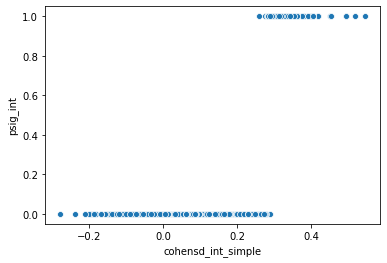

In [12]:
results_sim = pd.read_csv('power_sim2_simpleRManova.csv')
results_sim['psig_int'] = (results_sim['int_pval_simple'] < .05).astype("int")
sns.scatterplot(x='cohensd_int_simple', y='psig_int', data=results_sim)

In [13]:
# use moving average
dvals = np.arange(0, 1, .05)
span = .05
power_ma = pd.DataFrame()
for i, d in enumerate(dvals):
    results_d = results_sim.query('cohensd_int_simple > %f & cohensd_int_simple < %f' % (d - span, d + span))
    power_ma.loc[i, 'd'] = d
    power_ma.loc[i, 'power_randslope'] = results_d.psig_int.mean()
    
power_ma

,d,power_randslope
0,0.00,0.000000
1,0.05,0.000000
2,0.10,0.000000
3,0.15,0.000000
4,0.20,0.000000
5,0.25,0.113333
6,0.30,0.606061
7,0.35,1.000000
8,0.40,1.000000
9,0.45,1.000000


In [6]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(results_sim.cohensd_int[:, np.newaxis], results_sim.int_param)
print(lr.coef_, lr.intercept_)

lr.intercept_ + lr.coef_[0]*.2

[2.4170076] 1.2927399613883714


1.7761414808262372

In [7]:
lr.predict(np.array([.5]).reshape((1,1)))

array([2.50124376])

In [10]:
results_sim

,Unnamed: 0,int_param,cohensd_int,int_pval,int_pval_simple,cohensd_int_simple,psig_int
0,0,NaN,NaN,NaN,0.980539,0.003339,0
1,1,NaN,NaN,NaN,0.280636,0.147877,0
2,2,NaN,NaN,NaN,0.579692,-0.075834,0
3,3,NaN,NaN,NaN,0.523667,-0.088798,0
4,4,NaN,NaN,NaN,0.239412,0.161291,0
...,...,...,...,...,...,...,...
995,995,NaN,NaN,NaN,0.654109,0.062375,0
996,996,NaN,NaN,NaN,0.552025,0.085769,0
997,997,NaN,NaN,NaN,0.269187,0.159529,0
998,998,NaN,NaN,NaN,0.242820,0.165665,0
